<a href="https://colab.research.google.com/github/drshahizan/Python_EDA/blob/main/Malaysia%20EDA/Pixelated/Lab/Pixelated_Lab_5_Dataset_285_million_users_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Group Members: 

TERENCE LOORTHANAATHAN (A20EC0165)


RISHMA FATHIMA BINTI BASHER (A20EC0137)

# eCommerce behavior data from multi category store
This dataset contains 285 million users' events from eCommerce website

[**Dataset**: eCommerce behavior data from multi category store](https://www.kaggle.com/datasets/mkechinov/ecommerce-behavior-data-from-multi-category-store)

**More datasets**
Due to Kaggle's limit to max 20Gb of files per dataset, I can' upload more data to this dataset. [Here you can find additional archives (Dec 2019 - Apr 2020)](https://drive.google.com/drive/folders/1Nan8X33H8xrXS5XhCKZmSpClFTCJsSpE).

Installing packages

In [ ]:

!pip install squarify
!pip install statsmodels
!pip install seaborn
!pip install xgboost
!pip install -q kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rishmafathima","key":"b837de16f46abc758b92fc56029a7ce2"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d mkechinov/ecommerce-behavior-data-from-multi-category-store

ecommerce-behavior-data-from-multi-category-store.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip ecommerce-behavior-data-from-multi-category-store.zip

Archive:  ecommerce-behavior-data-from-multi-category-store.zip
replace 2019-Nov.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: 2019-Nov.csv            y
y


importing libraries

In [ ]:

import numpy as np 
import pandas as pd 
import os
from statsmodels import api as sm
import pylab as py
import matplotlib.pyplot as plt
import matplotlib.dates as dates
from datetime import datetime
import matplotlib.ticker as ticker
import matplotlib.cm as cm
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
import seaborn as sns
import squarify
from scipy.stats import kstest,norm
from scipy.stats import norm
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from xgboost import plot_importance
from sklearn.utils import resample
from sklearn import metrics
from scipy.stats import chi2_contingency

## Reduce memory usage

In [ ]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

Please enter the file location and name.

In [ ]:
df = pd.read_csv('/content/2019-Nov.csv')
df=reduce_mem_usage(df)

Memory usage after optimization is: 445.56 MB
Decreased by 25.0%


In [ ]:
df.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-11-01 00:00:00 UTC,view,1003461,2.053014e+18,electronics.smartphone,xiaomi,489.0000,520088896.0,4d3b30da-a5e4-49df-b1a8-ba5943f1dd33
1,2019-11-01 00:00:00 UTC,view,5000088,2.053014e+18,appliances.sewing_machine,janome,293.7500,530496800.0,8e5f4f83-366c-4f70-860e-ca7417414283
2,2019-11-01 00:00:01 UTC,view,17302664,2.053014e+18,NaN,creed,28.3125,561587264.0,755422e7-9040-477b-9bd2-6a6e8fd97387
3,2019-11-01 00:00:01 UTC,view,3601530,2.053014e+18,appliances.kitchen.washer,lg,713.0000,518085600.0,3bfb58cd-7892-48cc-8020-2f17e6de6e7f
4,2019-11-01 00:00:01 UTC,view,1004775,2.053014e+18,electronics.smartphone,xiaomi,183.2500,558856704.0,313628f1-68b8-460d-84f6-cec7a8796ef2


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8651914 entries, 0 to 8651913
Data columns (total 9 columns):
 #   Column         Dtype  
---  ------         -----  
 0   event_time     object 
 1   event_type     object 
 2   product_id     int32  
 3   category_id    float32
 4   category_code  object 
 5   brand          object 
 6   price          float16
 7   user_id        float32
 8   user_session   object 
dtypes: float16(1), float32(2), int32(1), object(5)
memory usage: 445.6+ MB


## Column

In [ ]:
#no of rows with null values
print("category_code ",df['category_code'].isnull().sum())
print("brand ",df['brand'].isnull().sum())
print("Both ",(df['category_code'].isnull() & df['brand'].isnull()).sum())

category_code  2843380
brand  1221563
Both  727019


In [ ]:
df = df.dropna()

In [ ]:
df.shape

(5313990, 9)

## No of visitors by date
To analyze the number of visitors by date we have grouped the dataset by columns event_time and user_id.

The no.of visitors on each date is extracted and shown in the graph below.

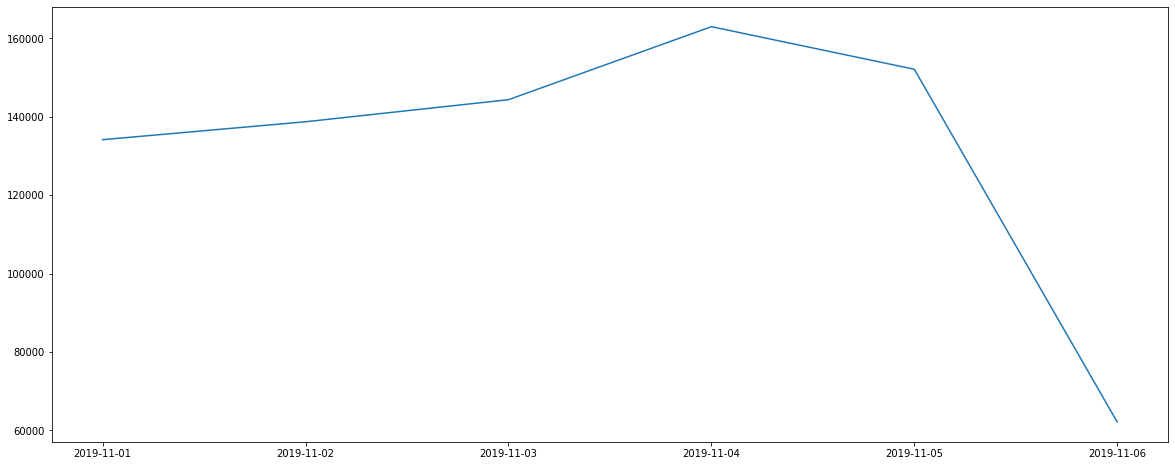

In [ ]:
#No of visitors by date
data = df.loc[:,['event_time','user_id']]
#Extracting only dates
data['event_time'] = data['event_time'].apply(lambda s: str(s)[0:10])
visitor_by_date = data.drop_duplicates().groupby(['event_time'])['user_id'].agg(['count']).sort_values(by=['event_time'], ascending=True)
x = pd.Series(visitor_by_date.index.values).apply(lambda s: datetime.strptime(s, '%Y-%m-%d').date())
y = visitor_by_date['count']
plt.rcParams['figure.figsize'] = (20,8)

plt.plot(x,y)
plt.show()

## Most bought brand


In [ ]:
df['brand'].value_counts()
df['event_type'].value_counts()

view        5130998
cart          93413
purchase      89579
Name: event_type, dtype: int64

            event_time  event_type  product_id  category_id  category_code  \
brand                                                                        
a-elita             26          26          26           26             26   
aardwolf            10          10          10           10             10   
abtoys              19          19          19           19             19   
accumaster          10          10          10           10             10   
acd                 12          12          12           12             12   
...                ...         ...         ...          ...            ...   
zorg                10          10          10           10             10   
zotac              107         107         107          107            107   
zte               1792        1792        1792         1792           1792   
zubr               655         655         655          655            655   
zwerg                2           2           2            2     

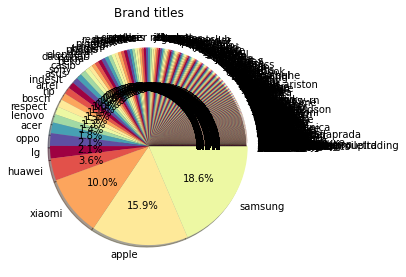

In [ ]:
title_type = df.groupby('brand').agg('count')
print(title_type)
type_labels = title_type.user_id.sort_values().index
type_counts = title_type.user_id.sort_values()
plt.figure(1,figsize =(20,10))
the_grid = GridSpec(2,2)
cmap = plt.get_cmap('Spectral')
colors = [cmap(i) for i in np.linspace(0,1,8)]
plt.subplot(the_grid[0,1],aspect=1,title = 'Brand titles')
type_show_ids = plt.pie(type_counts,labels = type_labels,autopct = '%1.1f%%',shadow = True,colors = colors)
plt.show()

## Popular product categories
A squarify plot is used to visually represent which categories of product has drawn more demand from customer.

Most of the items are given two category codes separated by a point.First word depicts the main category of the item whereas the following word depicts its sub category.

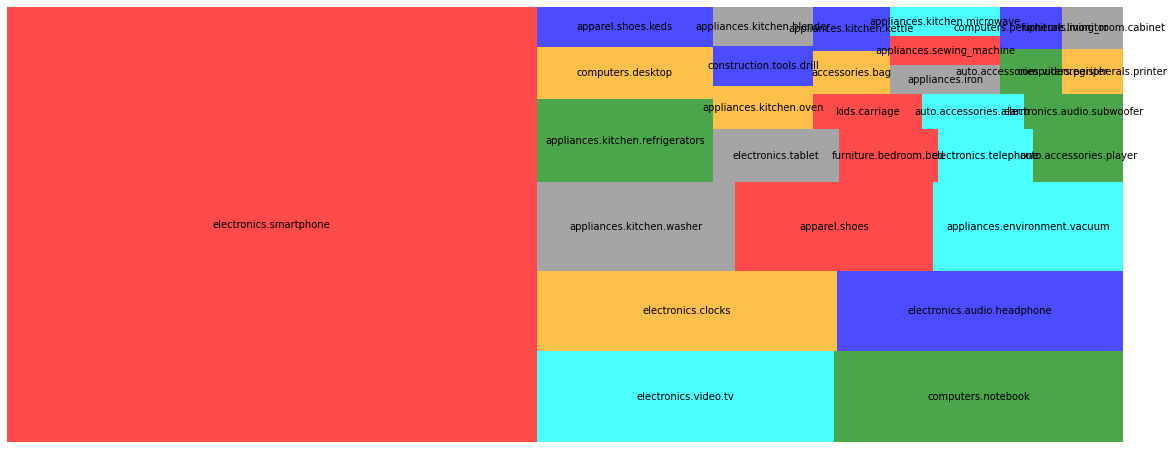

In [ ]:
top_category_n = 30
top_category = df.loc[:,'category_code'].value_counts()[:top_category_n].sort_values(ascending=False)
squarify.plot(sizes=top_category, label=top_category.index.array, color=["red","cyan","green","orange","blue","grey"], alpha=.7  )
plt.axis('off')
plt.show()

"Smartphones" which comes under electronics goods are more popular.

A huge fraction of items bought are electronics which concludes there have been major discounts and price deals available on ecommerce platform.

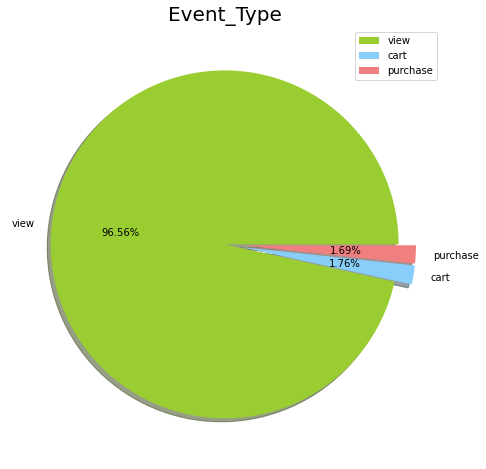

In [ ]:
labels = ['view', 'cart','purchase']
size = df['event_type'].value_counts()
colors = ['yellowgreen', 'lightskyblue','lightcoral']
explode = [0, 0.1,0.1]

plt.rcParams['figure.figsize'] = (8, 8)
plt.pie(size, colors = colors, explode = explode, labels = labels, shadow = True, autopct = '%.2f%%')
plt.title('Event_Type', fontsize = 20)
plt.axis('off')
plt.legend()
plt.show()

## Conversion Rates
We have three type of events view,add to cart and purchase.Not every user view ,add it to the cart and purchase it.Most users tend to have look at the product and its price.

Conversion rates gives us the idea of how many users actually purchased the product as opposed to how many times the products are viewed or added to the cart.

How many products are actually purchased as opposed to number of products added to the cart.

We find

1.Count of people who viewed the item.

2.Count of people who added the item to cart.

3.Count of people who bought the item.

In [ ]:
view_count = df['event_type'].value_counts()[0]
cart_count = df['event_type'].value_counts()[1]
purchase_count = df['event_type'].value_counts()[2]
print("Rate of conversion between view and purchase events" +str((purchase_count/view_count)*100) +'%')
print("Rate of conversion between view and add to cart events" +str((cart_count/view_count)*100) +'%')
print("Rate of conversion between add to cart and purchase events" +str((purchase_count/cart_count)*100) +'%')

Rate of conversion between view and purchase events1.7458396982419404%
Rate of conversion between view and add to cart events1.8205620037271502%
Rate of conversion between add to cart and purchase events95.8956462162654%


## Brandwise sales of all event types¶


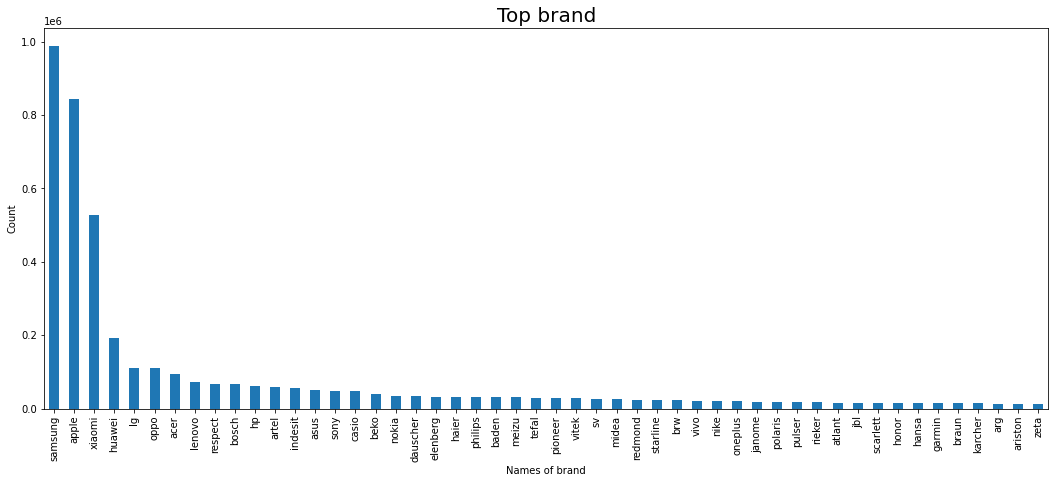

In [ ]:
#Brandwise sales of all event types
df['brand'].value_counts().head(50).plot.bar(figsize = (18,7))
plt.title('Top brand',fontsize = 20)
plt.xlabel('Names of brand')
plt.ylabel('Count')
plt.show()

We consider only purchase events which tells us which brand is the first player in the market

samsung        28525
apple          24430
xiaomi          7355
huawei          3341
oppo            1964
               ...  
versace            1
kettler            1
ag                 1
rheinberger        1
bair               1
Name: brand, Length: 691, dtype: int64


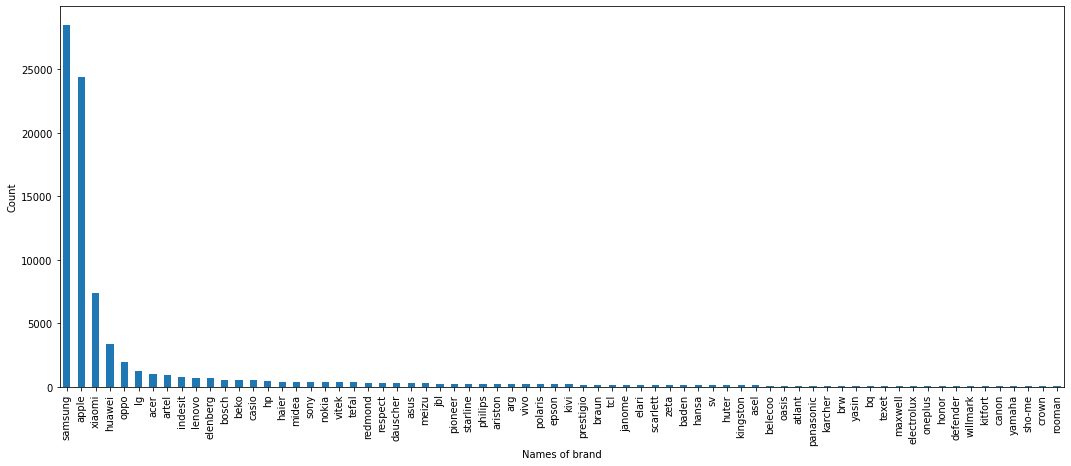

In [ ]:
d = df.loc[df['event_type'].isin(['purchase'])].drop_duplicates()
print(d['brand'].value_counts())
d['brand'].value_counts().head(70).plot.bar(figsize =(18,7))
plt.xlabel('Names of brand')
plt.ylabel('Count')
plt.show()

In [ ]:
top_player = df['brand'].value_counts()[0]
second_player = df['brand'].value_counts()[1]
last_player = df['brand'].value_counts()[-1]
print("Top brand saw " +str((top_player/second_player)*100)+"%more sales than second_player in the market")
print("Top brand saw " +str((top_player/last_player)*100)+"%more sales than bottom player in the market")

Top brand saw 117.25001008765578%more sales than second_player in the market
Top brand saw 98796500.0%more sales than bottom player in the market


## Purchase path
The standard idea is that most people first view an item,compare with other item and add to cart to buy specific item.not many people follow this path.

Given below is an example of customer who followed the path view->cart->purchase

In [ ]:
df.loc[df.user_session =="ef3daa59-4936-43e5-a530-32902f64b2f4"].sort_values(by = "event_time")

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
2169,2019-11-01 00:14:32 UTC,view,1005105,2.053014e+18,electronics.smartphone,apple,1349.0,518840512.0,ef3daa59-4936-43e5-a530-32902f64b2f4
2275,2019-11-01 00:15:10 UTC,cart,1005105,2.053014e+18,electronics.smartphone,apple,1349.0,518840512.0,ef3daa59-4936-43e5-a530-32902f64b2f4
2309,2019-11-01 00:15:23 UTC,purchase,1005105,2.053014e+18,electronics.smartphone,apple,1349.0,518840512.0,ef3daa59-4936-43e5-a530-32902f64b2f4
2374,2019-11-01 00:15:46 UTC,view,1005105,2.053014e+18,electronics.smartphone,apple,1349.0,518840512.0,ef3daa59-4936-43e5-a530-32902f64b2f4


## User's journey
The code below shows the user who purchased a apple product after which he views other products manufactured by the same company "apple".

In [ ]:
user_ID = 518267348
df.loc[df['user_id'] == user_ID]

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
1748,2019-11-01 00:11:48 UTC,view,1005129,2.053014e+18,electronics.smartphone,apple,1337.0,518267360.0,61f913b1-ed5f-4495-8139-7e3e20be92c3
1822,2019-11-01 00:12:16 UTC,cart,1005129,2.053014e+18,electronics.smartphone,apple,1337.0,518267360.0,61f913b1-ed5f-4495-8139-7e3e20be92c3
1951,2019-11-01 00:13:10 UTC,purchase,1005129,2.053014e+18,electronics.smartphone,apple,1337.0,518267360.0,61f913b1-ed5f-4495-8139-7e3e20be92c3
2285,2019-11-01 00:15:14 UTC,view,1005105,2.053014e+18,electronics.smartphone,apple,1349.0,518267360.0,af95bb12-1956-40a4-a703-fcae492b2fb6
2520,2019-11-01 00:16:46 UTC,view,1005129,2.053014e+18,electronics.smartphone,apple,1337.0,518267360.0,4a1fa3dc-f7ed-4880-8e86-9b9f87045464
2678,2019-11-01 00:17:47 UTC,view,1005129,2.053014e+18,electronics.smartphone,apple,1337.0,518267360.0,4a1fa3dc-f7ed-4880-8e86-9b9f87045464
2706,2019-11-01 00:17:57 UTC,view,1005105,2.053014e+18,electronics.smartphone,apple,1349.0,518267360.0,4a1fa3dc-f7ed-4880-8e86-9b9f87045464
2800,2019-11-01 00:18:32 UTC,view,1005105,2.053014e+18,electronics.smartphone,apple,1349.0,518267360.0,4a1fa3dc-f7ed-4880-8e86-9b9f87045464
2868,2019-11-01 00:18:57 UTC,view,1005105,2.053014e+18,electronics.smartphone,apple,1349.0,518267360.0,4a1fa3dc-f7ed-4880-8e86-9b9f87045464
2875,2019-11-01 00:19:00 UTC,view,1005105,2.053014e+18,electronics.smartphone,apple,1349.0,518267360.0,4a1fa3dc-f7ed-4880-8e86-9b9f87045464


## Chunksize = 10000

In [ ]:
df = pd.read_csv('/content/2019-Nov.csv', chunksize=100000)

In [ ]:
output = pd.DataFrame()
for chunk in df:
    categories = ['brand','category_code','event_type']
    details = chunk[categories]
    details['count'] = 1
    summary = details.groupby(categories).sum().reset_index()
    output = output.append(summary, ignore_index=True)

<ipython-input-31-4a6757a265a1>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  details['count'] = 1


In [ ]:
final_output = output.groupby(categories).sum().reset_index()

In [ ]:
final_output.to_csv('aggregated-consumer-info-Nov-2019.csv', index=False)